### Imports necesarios 


In [2]:
import pandas as pd
import re
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
import seaborn as sns



### Importamos y preparamos el DataSet para su uso

In [7]:
# Cargar el libro de trabajo con openpyxl, pidiendo solo los datos
workbook = openpyxl.load_workbook(r"C:\Users\maxi\DATA SCIENCE\REPOS\ML_Botany\data\raw\Datos_estadística.xlsx", data_only=True)
sheet = workbook.active 

# Extraer encabezados de la primera fila
headers = [cell.value for cell in sheet[1]]

# Extraer datos de las filas siguientes
data = []
for row_idx in range(2, sheet.max_row + 1): # Desde la segunda fila hasta el final
    row_values = [sheet.cell(row=row_idx, column=col_idx).value for col_idx in range(1, sheet.max_column + 1)]
    data.append(row_values)


df = pd.DataFrame(data, columns=headers)
# Eliminamos la columnas llena de "None"
df = df.iloc[:,:53]

# Limpiamos de espacios problemáticos, y los cambiamos por "_" para trabajar mejor con los nombres de las columnas.
column_names = df.columns
new_column_names = []

for col in column_names:
    # Usamos re.sub para manejar múltiples espacios como uno solo
    
    cleaned_col = re.sub(r'\s+', '_', col.strip())
    new_column_names.append(cleaned_col)

df.columns = new_column_names

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 799 entries, 0 to 798
Data columns (total 53 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Block                                  799 non-null    int64  
 1   Position                               799 non-null    int64  
 2   Code                                   799 non-null    int64  
 3   Treatment                              799 non-null    int64  
 4   Replicate                              799 non-null    int64  
 5   Peso_de_muestra_vegetal_(g)            799 non-null    float64
 6   Cantidad_de_N_en_muestra_vegetal_(g)   799 non-null    float64
 7   Cantidad_de_C_en_muestra_vegetal_(g)   799 non-null    float64
 8   Porcentaje_N_de_la_muestra_vegetal     799 non-null    float64
 9   Porcentaje_C_de_la_muestra_vegetal     799 non-null    float64
 10  Peso_de_muestra_de_fruto_(g)           799 non-null    float64
 11  Cantid

In [8]:
df

,Block,Position,Code,Treatment,Replicate,Peso_de_muestra_vegetal_(g),Cantidad_de_N_en_muestra_vegetal_(g),Cantidad_de_C_en_muestra_vegetal_(g),Porcentaje_N_de_la_muestra_vegetal,Porcentaje_C_de_la_muestra_vegetal,...,Biomasa_total_fresca,Biomasa_total_seca,Harvest_Index_S_(His),Root_Index_(Ri),CHLOR,FLV,ANT,NBI,NDVI,PhipII
0,2,375,1,100,1,0.0843,0.00214,0.0306,2.53338,36.27933,...,905.650,166.889,0.020906,0.085086,30.626,0.568,0.214,53.96,0.626689,0.856
1,2,181,1,100,2,0.0860,0.00239,0.0325,2.78006,37.77989,...,1193.085,201.468,0.033593,0.085373,30.129,0.492,0.198,61.23,0.616728,0.790
2,1,246,1,100,3,0.0846,0.00205,0.0327,2.42762,38.70086,...,856.936,146.899,0.032669,0.090538,25.620,0.534,0.208,47.97,0.644530,0.861
3,2,357,2,100,1,0.0851,0.00180,0.0318,2.11269,37.40876,...,838.955,136.202,0.097664,0.154183,29.626,0.549,0.215,54.01,0.620586,0.859
4,2,241,2,100,2,0.0857,0.00173,0.0336,2.01700,39.21480,...,776.498,147.557,0.082389,0.112499,33.623,0.523,0.196,64.33,0.644228,0.819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,2,54,128,50,1,0.0847,0.00187,0.0285,2.20418,33.65301,...,681.616,95.551,0.087398,0.097330,27.695,0.654,0.214,42.34,0.602313,0.847
795,1,51,128,50,2,0.0857,0.00161,0.0312,1.88218,36.35692,...,502.215,93.798,0.081004,0.124736,24.488,0.790,0.228,31.01,0.598074,0.850
796,1,243,128,50,3,0.0864,0.00153,0.0328,1.77586,37.90731,...,432.179,76.038,0.150425,0.086799,20.846,0.505,0.278,41.28,0.619823,0.829
797,1,167,128,50,4,0.0863,0.00196,0.0321,2.27617,37.16062,...,304.105,39.084,0.032852,0.063965,22.583,0.506,0.232,44.64,0.631110,0.854


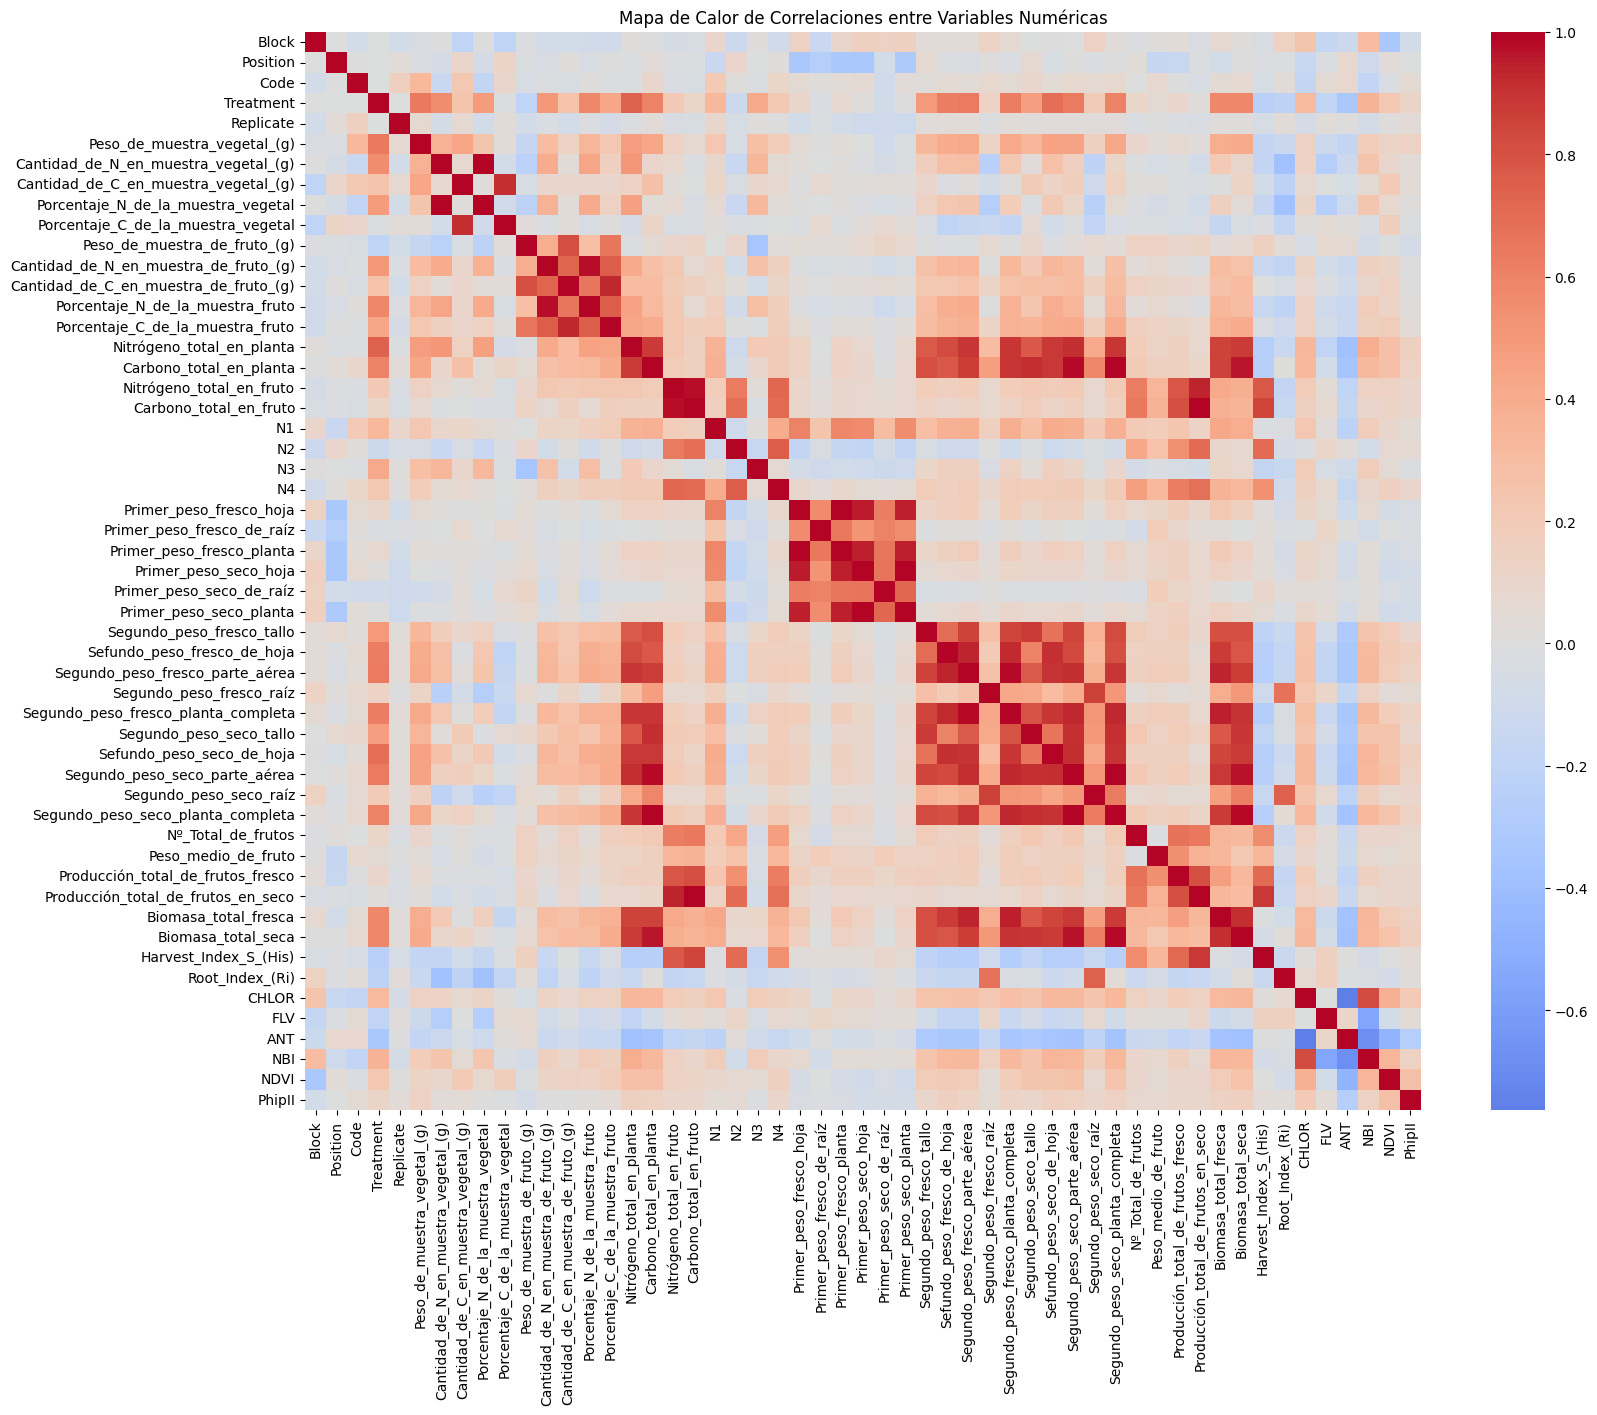

In [9]:
plt.figure(figsize=(18, 14))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Mapa de Calor de Correlaciones entre Variables Numéricas")
plt.show()

In [10]:
# Buscar relaciones fuertes (|correlación| > 0.85), pero no 1.0
strong_corrs = []
threshold = 0.85

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        col1 = corr_matrix.columns[i]
        col2 = corr_matrix.columns[j]
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > threshold:
            strong_corrs.append((col1, col2, corr_value))

# Mostrar correlaciones fuertes ordenadas
strong_corrs_sorted = sorted(strong_corrs, key=lambda x: -abs(x[2]))
print("\n🔗 Correlaciones fuertes (|r| > 0.85):\n")
for col1, col2, val in strong_corrs_sorted:
    print(f"{col1:<25} <-> {col2:<25} | r = {val:.3f}")


🔗 Correlaciones fuertes (|r| > 0.85):

Primer_peso_seco_hoja     <-> Primer_peso_seco_planta   | r = 0.997
Primer_peso_fresco_hoja   <-> Primer_peso_fresco_planta | r = 0.994
Cantidad_de_N_en_muestra_vegetal_(g) <-> Porcentaje_N_de_la_muestra_vegetal | r = 0.992
Carbono_total_en_fruto    <-> Producción_total_de_frutos_en_seco | r = 0.989
Segundo_peso_seco_parte_aérea <-> Segundo_peso_seco_planta_completa | r = 0.989
Carbono_total_en_planta   <-> Segundo_peso_seco_planta_completa | r = 0.986
Segundo_peso_fresco_parte_aérea <-> Segundo_peso_fresco_planta_completa | r = 0.986
Carbono_total_en_planta   <-> Segundo_peso_seco_parte_aérea | r = 0.982
Segundo_peso_seco_planta_completa <-> Biomasa_total_seca        | r = 0.980
Cantidad_de_N_en_muestra_de_fruto_(g) <-> Porcentaje_N_de_la_muestra_fruto | r = 0.979
Nitrógeno_total_en_fruto  <-> Carbono_total_en_fruto    | r = 0.973
Segundo_peso_seco_parte_aérea <-> Biomasa_total_seca        | r = 0.969
Carbono_total_en_planta   <-> Biomasa_total_

### Retiramos los datos de la segunda extracción, pera entrenar el modelo 

In [11]:
df_train_1 = df.drop(columns=[
        'Block',
        'Position',
        'Segundo_peso_fresco_tallo',
        'Sefundo_peso_fresco_de_hoja',
        'Segundo_peso_fresco_parte_aérea',
        'Segundo_peso_fresco_raíz',
        'Segundo_peso_fresco_planta_completa',
        'Segundo_peso_seco_tallo',
        'Sefundo_peso_seco_de_hoja',
        'Segundo_peso_seco_parte_aérea',
        'Segundo_peso_seco_raíz',
        'Segundo_peso_seco_planta_completa',
        'Nº_Total_de_frutos',
        'Peso_medio_de_fruto',
        'Producción_total_de_frutos_fresco',
        'Producción_total_de_frutos_en_seco',
        'Biomasa_total_fresca',
        'Biomasa_total_seca',
        'Replicate'
], axis=1)

In [12]:
df_train = df_train_1.iloc[359:]

df_train

,Code,Treatment,Peso_de_muestra_vegetal_(g),Cantidad_de_N_en_muestra_vegetal_(g),Cantidad_de_C_en_muestra_vegetal_(g),Porcentaje_N_de_la_muestra_vegetal,Porcentaje_C_de_la_muestra_vegetal,Peso_de_muestra_de_fruto_(g),Cantidad_de_N_en_muestra_de_fruto_(g),Cantidad_de_C_en_muestra_de_fruto_(g),...,Primer_peso_seco_de_raíz,Primer_peso_seco_planta,Harvest_Index_S_(His),Root_Index_(Ri),CHLOR,FLV,ANT,NBI,NDVI,PhipII
359,121,100,0.0868,0.00217,0.0311,2.49926,35.84504,0.1256,0.00355,0.0619,...,0.140,1.880,0.058773,0.103902,28.609,0.582,0.209,49.19,0.634030,0.893
360,121,100,0.0858,0.00181,0.0306,2.10585,35.61297,0.1263,0.00332,0.0614,...,0.080,0.880,0.040778,0.127431,27.059,0.626,0.217,43.21,0.640532,0.854
361,121,100,0.0849,0.00206,0.0308,2.43110,36.27081,0.1288,0.00348,0.0637,...,0.060,0.790,0.049083,0.132964,27.659,0.606,0.248,45.61,0.638879,0.864
362,121,100,0.0860,0.00204,0.0309,2.37291,35.91199,0.1278,0.00382,0.0616,...,0.120,1.430,0.042206,0.117007,29.620,0.684,0.216,43.33,0.651568,0.898
363,121,100,0.0861,0.00192,0.0317,2.23038,36.82250,0.1252,0.00346,0.0598,...,0.060,0.810,0.035687,0.122606,30.667,0.609,0.198,50.32,0.613946,0.849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,128,50,0.0847,0.00187,0.0285,2.20418,33.65301,0.1405,0.00299,0.0634,...,0.073,0.923,0.087398,0.097330,27.695,0.654,0.214,42.34,0.602313,0.847
795,128,50,0.0857,0.00161,0.0312,1.88218,36.35692,0.1419,0.00376,0.0739,...,0.111,1.425,0.081004,0.124736,24.488,0.790,0.228,31.01,0.598074,0.850
796,128,50,0.0864,0.00153,0.0328,1.77586,37.90731,0.1402,0.00250,0.0611,...,0.188,1.355,0.150425,0.086799,20.846,0.505,0.278,41.28,0.619823,0.829
797,128,50,0.0863,0.00196,0.0321,2.27617,37.16062,0.1400,0.00432,0.0701,...,0.103,1.172,0.032852,0.063965,22.583,0.506,0.232,44.64,0.631110,0.854


### Generamos una fila de referéncia con la media de las características de los parentales que no reciben el tratamiento

In [13]:

df_solo_100 = df_train[df_train.loc[:,'Treatment'] == 100]

df_guía = pd.DataFrame(df_solo_100.mean())

df_guía = df_guía.T
df_guía = df_guía.drop(columns=["Treatment", "Code"], axis=1)
df_guía



,Peso_de_muestra_vegetal_(g),Cantidad_de_N_en_muestra_vegetal_(g),Cantidad_de_C_en_muestra_vegetal_(g),Porcentaje_N_de_la_muestra_vegetal,Porcentaje_C_de_la_muestra_vegetal,Peso_de_muestra_de_fruto_(g),Cantidad_de_N_en_muestra_de_fruto_(g),Cantidad_de_C_en_muestra_de_fruto_(g),Porcentaje_N_de_la_muestra_fruto,Porcentaje_C_de_la_muestra_fruto,...,Primer_peso_seco_de_raíz,Primer_peso_seco_planta,Harvest_Index_S_(His),Root_Index_(Ri),CHLOR,FLV,ANT,NBI,NDVI,PhipII
0,0.085803,0.002069,0.03106,2.411298,36.204862,0.123203,0.003513,0.060558,2.780766,47.921109,...,0.096775,0.850025,0.044449,0.10197,26.519,0.57645,0.215825,46.367,0.639494,0.856


In [14]:
df_guía.to_csv("df_guia.csv")

### Aislamos las plantas que han recibido el tratamiento

In [15]:
df_solo_50 = df_train[df_train.loc[:,'Treatment'] == 50]
df_solo_50

# Quitamos los parentales que reciben el tratamiento (Los que tienen el código del 121 al 128)

indices_to_drop = df_solo_50[df_solo_50["Code"].isin([121, 122, 123, 124, 125, 126, 127, 128])].index

df_solo_50 = df_solo_50.drop(indices_to_drop)


df_solo_50 = df_solo_50.drop(["Code","Treatment"], axis=1)
df_solo_50


,Peso_de_muestra_vegetal_(g),Cantidad_de_N_en_muestra_vegetal_(g),Cantidad_de_C_en_muestra_vegetal_(g),Porcentaje_N_de_la_muestra_vegetal,Porcentaje_C_de_la_muestra_vegetal,Peso_de_muestra_de_fruto_(g),Cantidad_de_N_en_muestra_de_fruto_(g),Cantidad_de_C_en_muestra_de_fruto_(g),Porcentaje_N_de_la_muestra_fruto,Porcentaje_C_de_la_muestra_fruto,...,Primer_peso_seco_de_raíz,Primer_peso_seco_planta,Harvest_Index_S_(His),Root_Index_(Ri),CHLOR,FLV,ANT,NBI,NDVI,PhipII
399,0.0807,0.00157,0.0276,1.94717,34.14634,0.2014,0.00429,0.0930,2.12985,46.19362,...,0.830,1.470,0.106558,0.112455,26.524,0.635,0.226,41.75,0.617190,0.840
400,0.0826,0.00210,0.0293,2.54313,35.44094,0.1063,0.00246,0.0480,2.31284,45.17220,...,0.257,2.397,0.061290,0.115760,27.021,0.486,0.212,55.59,0.634892,0.797
401,0.0804,0.00160,0.0258,1.99398,32.04726,0.1301,0.00325,0.0593,2.49843,45.54455,...,0.123,0.945,0.110955,0.097109,20.573,0.615,0.253,33.43,0.608619,0.861
402,0.0835,0.00195,0.0275,2.33461,32.99265,0.1717,0.00330,0.0775,1.92144,45.11496,...,0.112,0.954,0.094592,0.061977,25.777,0.545,0.215,47.33,0.624273,0.880
403,0.0819,0.00165,0.0253,2.02058,30.94491,0.1408,0.00313,0.0627,2.22210,44.55617,...,0.164,1.215,0.068038,0.092370,29.995,0.535,0.199,56.01,0.634733,0.841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0.0847,0.00187,0.0303,2.20945,35.83212,0.1399,0.00316,0.0716,2.25635,51.20695,...,0.166,1.569,0.107955,0.095822,20.815,0.537,0.257,38.78,0.629510,0.848
755,0.0879,0.00194,0.0316,2.20147,36.00384,0.1394,0.00232,0.0564,1.66403,40.45295,...,0.154,1.471,0.110131,0.068236,19.389,0.515,0.279,37.65,0.608075,0.826
756,0.0858,0.00190,0.0319,2.21499,37.23763,0.1401,0.00239,0.0559,1.70314,39.87738,...,0.212,2.158,0.127614,0.125378,26.911,0.581,0.219,46.28,0.549691,0.850
757,0.0859,0.00192,0.0316,2.23619,36.73604,0.1417,0.00342,0.0711,2.41560,50.15136,...,0.201,1.774,0.094067,0.092619,25.788,0.568,0.209,45.44,0.646614,0.861


In [16]:
df_solo_50.to_csv("df_solo_50.csv")

## HeatMap para visualizar las correlaciones

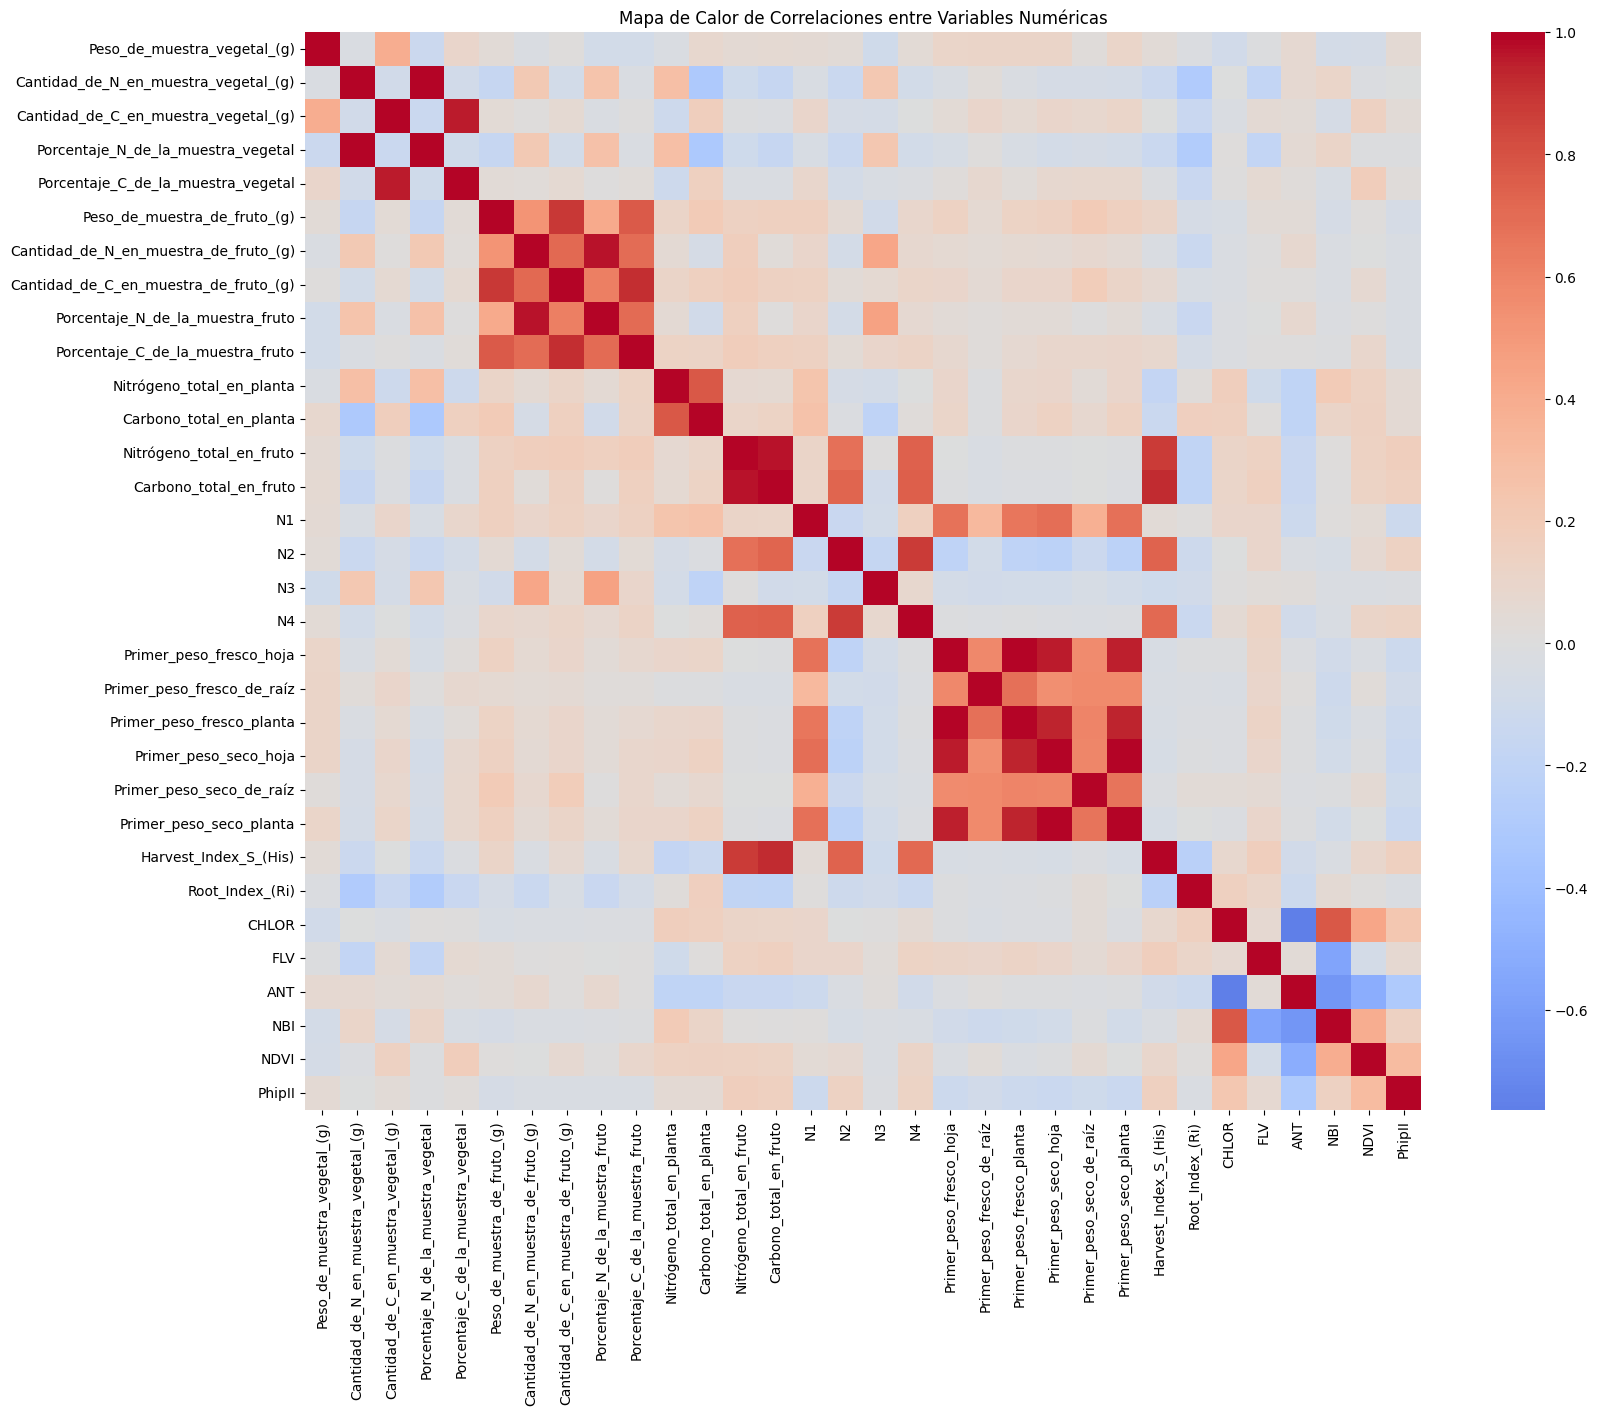

In [17]:
plt.figure(figsize=(18, 14))
corr_matrix = df_solo_50.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0)
plt.title("Mapa de Calor de Correlaciones entre Variables Numéricas")
plt.show()

In [18]:
medias = {
    "Peso_de_muestra_vegetal_(g)": 0.082858,
    "Cantidad_de_N_en_muestra_vegetal_(g)": 0.001824,
    "Cantidad_de_C_en_muestra_vegetal_(g)": 0.030109,
    "Porcentaje_N_de_la_muestra_vegetal": 2.202813,
    "Porcentaje_C_de_la_muestra_vegetal": 36.332893,
    "Peso_de_muestra_de_fruto_(g)": 0.136284,
    "Cantidad_de_N_en_muestra_de_fruto_(g)": 0.002890,
    "Cantidad_de_C_en_muestra_de_fruto_(g)": 0.060121,
    "Porcentaje_N_de_la_muestra_fruto": 2.093633,
    "Porcentaje_C_de_la_muestra_fruto": 43.509410,
    "Nitrógeno_total_en_planta": 1.969792,
    "Carbono_total_en_planta": 32.903757,
    "Nitrógeno_total_en_fruto": 0.219083,
    "Carbono_total_en_fruto": 4.629583,
    "N1": 301.777730,
    "N2": 213.451981,
    "N3": 0.021249,
    "N4": 1300.986678,
    "Primer_peso_fresco_hoja": 14.367061,
    "Primer_peso_fresco_de_raíz": 2.176344,
    "Primer_peso_fresco_planta": 16.543406,
    "Primer_peso_seco_hoja": 1.269825,
    "Primer_peso_seco_de_raíz": 0.171594,
    "Primer_peso_seco_planta": 1.441419,
    "Harvest_Index_S_(His)": 0.102025,
    "Root_Index_(Ri)": 0.107169,
    "CHLOR": 24.530192,
    "FLV": 0.586042,
    "ANT": 0.235539,
    "NBI": 42.449389,
    "NDVI": 0.612989,
    "PhipII": 0.845369
}


In [24]:
df_guia= pd.read_csv(r"C:\Users\maxi\DATA SCIENCE\REPOS\ML_Botany\data\processed\df_guia.csv")

medias_series = pd.Series(medias)

# Calcular cuántas columnas deben superar la media 
umbral_columnas = 10

# Creamos un DataFrame booleano donde True indica que el valor supera la media
condiciones_superan_media = df_solo_50[medias_series.index] > medias_series
df_train_final = df_solo_50[condiciones_superan_media.sum(axis=1) >= umbral_columnas].copy()

df_train_final["success"] = 0

columnas_comunes = df_train_final.columns.intersection(df_guia.columns)

umbral_exito = 0.5
for idx, fila in df_train_final.iterrows():
    proporcion_superior = (fila[columnas_comunes] >= df_guia.loc[0, columnas_comunes]).mean()
    if proporcion_superior >= umbral_exito:
        df_train_final.at[idx, "success"] = 1

df_train_final["success"].value_counts()

success
0    230
1     89
Name: count, dtype: int64

In [25]:
X = df_train_final.drop(columns=["success"])
y = df_train_final["success"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


modelos = {
    "RandomForest": (RandomForestClassifier(), {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [5, 10, None]
    }),
    "XGBoost": (XGBClassifier(eval_metric='logloss'), {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 6,9]
    }),
    "KNN": (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7]
    }),
    "GradientBoosting": (GradientBoostingClassifier(), {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }),
    "LogisticRegression": (LogisticRegression(max_iter=1000), {
        'C': [0.1, 1.0, 10]
    })
}

# Buscar mejor modelo
mejor_modelo = None
mejor_score = 0
mejor_nombre = ""
mejor_grid = None

for nombre, (modelo, params) in modelos.items():
    print(f"Entrenando {nombre}...")
    grid = GridSearchCV(modelo, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    score = grid.best_score_
    print(f"Mejor F1 para {nombre}: {score:.4f}")
    print("Mejores parámetros:", grid.best_params_)

    if score > mejor_score:
        mejor_score = score
        mejor_modelo = grid.best_estimator_
        mejor_nombre = nombre
        mejor_grid = grid

# Guardar el mejor modelo y el scaler
print(f"\n➡️ Mejor modelo: {mejor_nombre} con F1={mejor_score:.4f}")
joblib.dump(mejor_modelo, "my_model.pkl")
joblib.dump(scaler, "scaler.pkl")


y_pred = mejor_modelo.predict(X_test)
print("\nReporte en el conjunto de test:")
print(classification_report(y_test, y_pred))



Entrenando RandomForest...
Mejor F1 para RandomForest: 0.6171
Mejores parámetros: {'max_depth': None, 'n_estimators': 150}
Entrenando XGBoost...
Mejor F1 para XGBoost: 0.7379
Mejores parámetros: {'max_depth': 9, 'n_estimators': 150}
Entrenando KNN...
Mejor F1 para KNN: 0.4788
Mejores parámetros: {'n_neighbors': 3}
Entrenando GradientBoosting...
Mejor F1 para GradientBoosting: 0.7118
Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Entrenando LogisticRegression...
Mejor F1 para LogisticRegression: 0.5770
Mejores parámetros: {'C': 10}

➡️ Mejor modelo: XGBoost con F1=0.7379

Reporte en el conjunto de test:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94        46
           1       0.93      0.72      0.81        18

    accuracy                           0.91        64
   macro avg       0.91      0.85      0.88        64
weighted avg       0.91      0.91      0.90        64



### Análisis de resultados: métrica adecuada

Dado que estamos clasificando plantas como success (1) o no success (0), y que el dataset original está desbalanceado (pocas clases positivas), la métrica adecuada es el F1-score, ya que:
No basta con la precisión si hay muchos 0s y F1 combina precisión y recall: penaliza falsos positivos y negativos.

              precision    recall  f1-score   support

           0       0.90      0.98      0.94        46
           1       0.93      0.72      0.81        18

    accuracy                           0.91        64
   macro avg       0.91      0.85      0.88        64
weighted avg       0.91      0.91      0.90        64



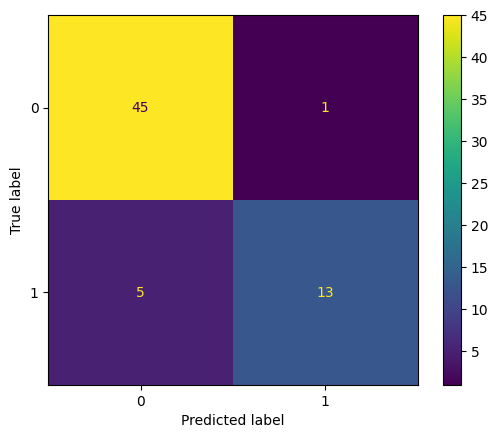

In [26]:
modelo = pickle.load(open(r"C:\Users\maxi\DATA SCIENCE\REPOS\ML_Botany\model\my_model.pkl", "rb"))

# Evaluar modelo en test
y_pred = modelo.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(modelo, X_test, y_test)


## Interpretación del modelo


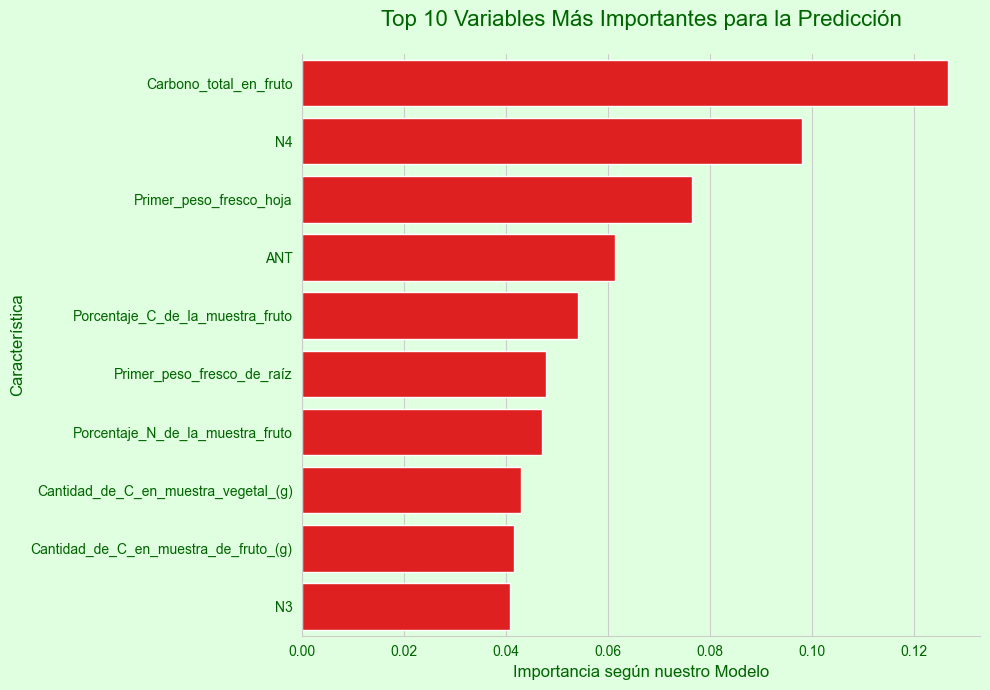

In [ ]:

modelo = joblib.load(r"C:\Users\maxi\DATA SCIENCE\REPOS\ML_Botany\model\my_model.pkl")


campos = [
    "Peso_de_muestra_vegetal_(g)", "Cantidad_de_N_en_muestra_vegetal_(g)", "Cantidad_de_C_en_muestra_vegetal_(g)",
    "Porcentaje_N_de_la_muestra_vegetal", "Porcentaje_C_de_la_muestra_vegetal",
    "Peso_de_muestra_de_fruto_(g)", "Cantidad_de_N_en_muestra_de_fruto_(g)", "Cantidad_de_C_en_muestra_de_fruto_(g)",
    "Porcentaje_N_de_la_muestra_fruto", "Porcentaje_C_de_la_muestra_fruto",
    "Nitrógeno_total_en_planta", "Carbono_total_en_planta", "Nitrógeno_total_en_fruto", "Carbono_total_en_fruto",
    "N1", "N2", "N3", "N4", "Primer_peso_fresco_hoja", "Primer_peso_fresco_de_raíz", "Primer_peso_fresco_planta",
    "Primer_peso_seco_hoja", "Primer_peso_seco_de_raíz", "Primer_peso_seco_planta",
    "Harvest_Index_S_(His)", "Root_Index_(Ri)", "CHLOR", "FLV", "ANT", "NBI", "NDVI", "PhipII"
]


importancias = modelo.feature_importances_

df_imp = pd.DataFrame({"feature": campos, "importance": importancias})
df_imp = df_imp.sort_values("importance", ascending=False).head(10)


sns.set_style("whitegrid")

plt.figure(figsize=(10, 7)) 

plt.gcf().set_facecolor('#E0FFE0') 
plt.gca().set_facecolor('#E0FFE0') 

sns.barplot(data=df_imp, x="importance", y="feature", color='red')

plt.title("Top 10 Variables Más Importantes para la Predicción", fontsize=16, color='darkgreen', pad=20)
plt.xlabel("Importancia según nuestro Modelo", fontsize=12, color='darkgreen')
plt.ylabel("Característica", fontsize=12, color='darkgreen')


plt.yticks(fontsize=10, color='darkgreen')
plt.xticks(fontsize=10, color='darkgreen')

sns.despine()
plt.tight_layout()

plt.show()